<a href="https://colab.research.google.com/github/armandoBringas/computer-vision-course/blob/sofi/7_harris_edge_corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7. Harris Edge & Corner Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Color image to Grayscale conversion](#grayscale)
3. [Spatial derivative calculation](#spatial)
4. [Structure tensor setup](#tensor)
5. [Harris response calculation](#response)
6. [Find edges and corners using R](#find)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [11]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from scipy.ndimage.filters import convolve

## 1. Color to Grayscale <a class="anchor" id="grayscale" ></a>

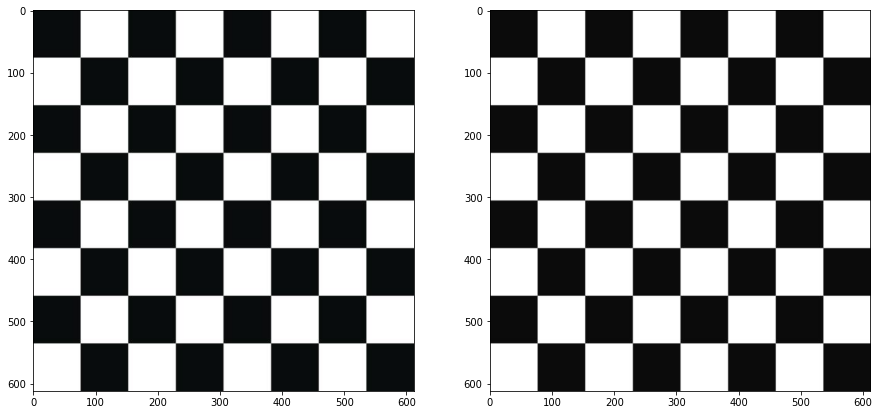

In [ ]:
img = cv2.imread('data/chessboard.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

## 2. Spatial derivative calculation <a class="anchor" id="spatial" ></a>

In [ ]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(img_gray)
I_y = gradient_y(img_gray)

## 3. Structure tensor setup <a class="anchor" id="tensor" ></a>

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

## 4. Harris response calculation <a class="anchor" id="response" ></a>

In [ ]:
k = 0.05

# determinant
detA = Ixx * Iyy - Ixy ** 2

# trace
traceA = Ixx + Iyy
    
harris_response = detA - k * traceA ** 2

In [ ]:
img_gray.shape

(612, 612)

In [ ]:
window_size = 3
offset = window_size//2
width, height = img_gray.shape

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

In [ ]:
#Find determinant and trace, use to get corner response
det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
r = det - k*(trace**2)

## 5. Find edges and corners using R <a class="anchor" id="find" ></a>

In [ ]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

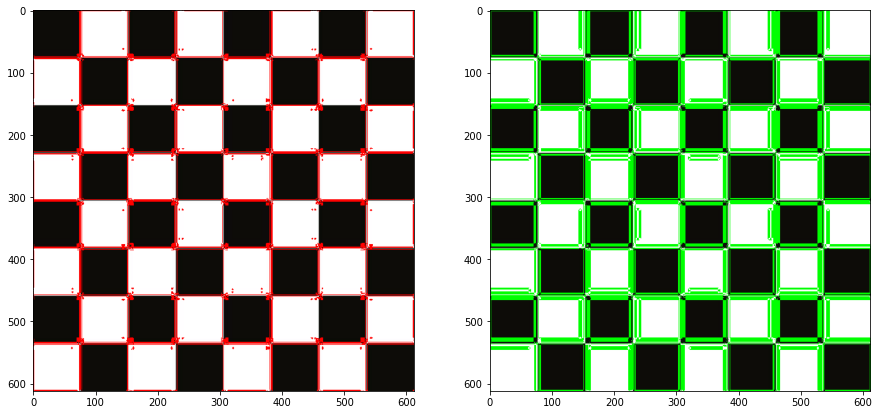

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")

#Exersices

## 1. Color to Grayscale <a class="anchor" id="grayscale" ></a>

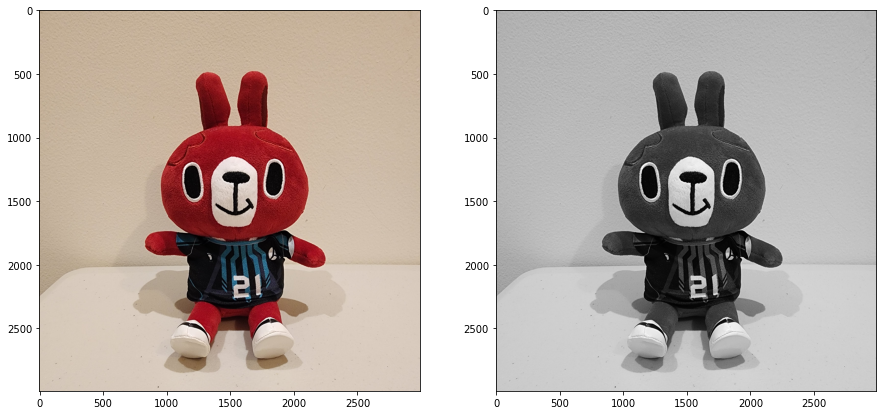

In [17]:
img = cv2.imread('/content/7_harris_edge/bunny_2.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

## 2. Spatial derivative calculation <a class="anchor" id="spatial" ></a>

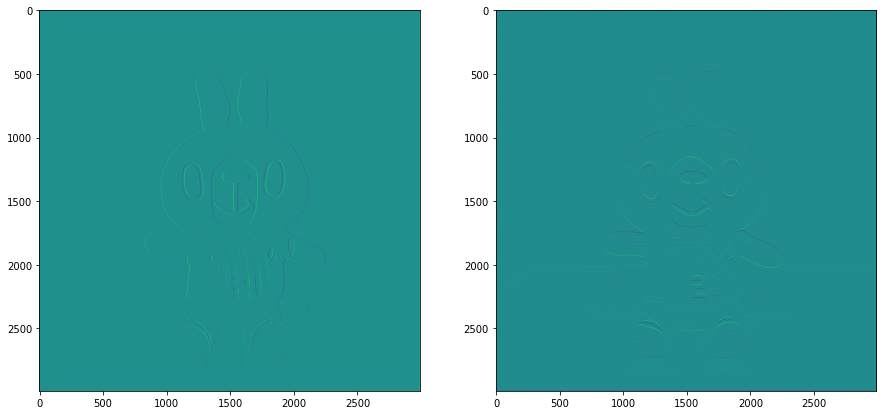

In [19]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')
    
I_x = gradient_x(img_gray)
I_y = gradient_y(img_gray)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(I_x)
plt.subplot(1, 2, 2)
plt.imshow(I_y)

## 3. Structure tensor setup <a class="anchor" id="tensor" ></a>

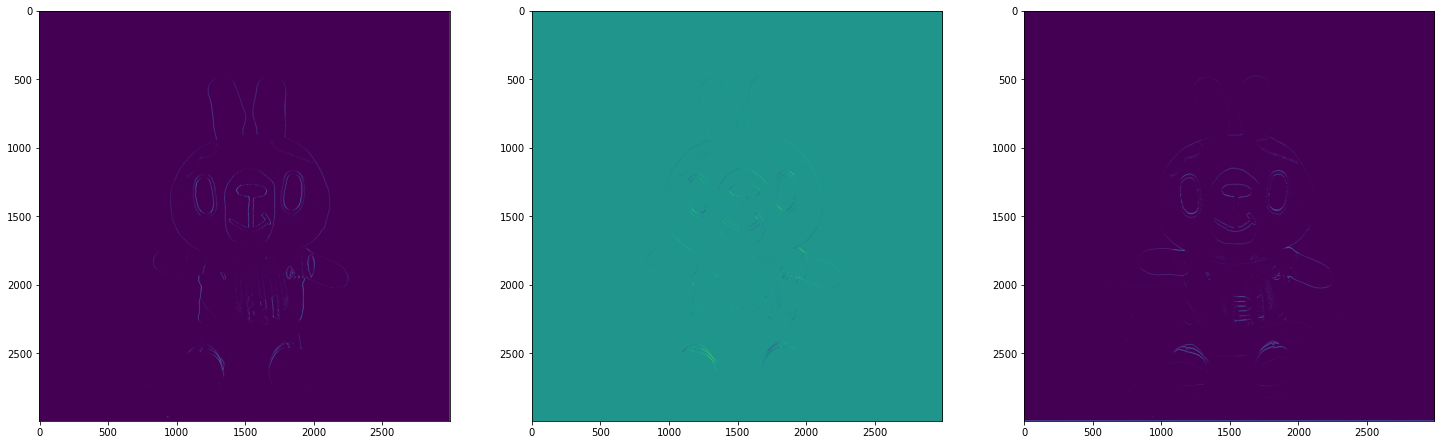

In [20]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

plt.figure(figsize=(25, 15))
plt.subplot(1, 3, 1)
plt.imshow(Ixx)
plt.subplot(1, 3, 2)
plt.imshow(Ixy)
plt.subplot(1, 3, 3)
plt.imshow(Iyy)

## 4. Harris response calculation <a class="anchor" id="response" ></a>

In [21]:
k = 0.05

# determinant
detA = Ixx * Iyy - Ixy ** 2

# trace
traceA = Ixx + Iyy
    
harris_response = detA - k * traceA ** 2

In [22]:
img_gray.shape

(2992, 2992)

In [23]:
window_size = 3
offset = window_size//2
width, height = img_gray.shape

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

In [24]:
#Find determinant and trace, use to get corner response
det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
r = det - k*(trace**2)

In [25]:
print(r)

1254585264445.75


## 5. Find edges and corners using R <a class="anchor" id="find" ></a>

In [26]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

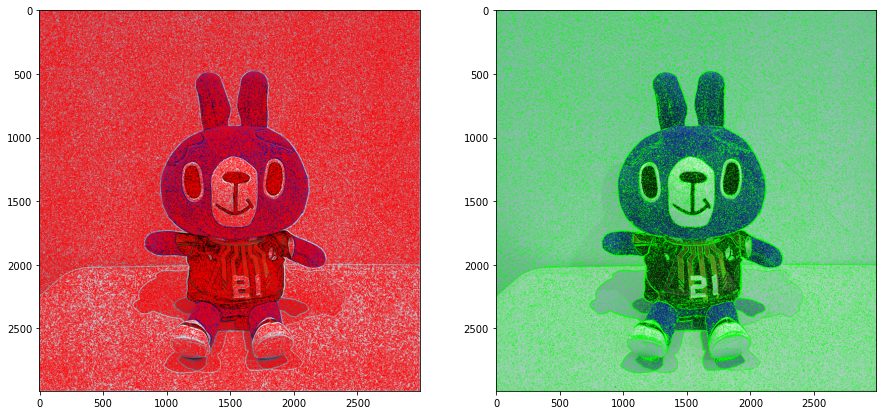

In [27]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")